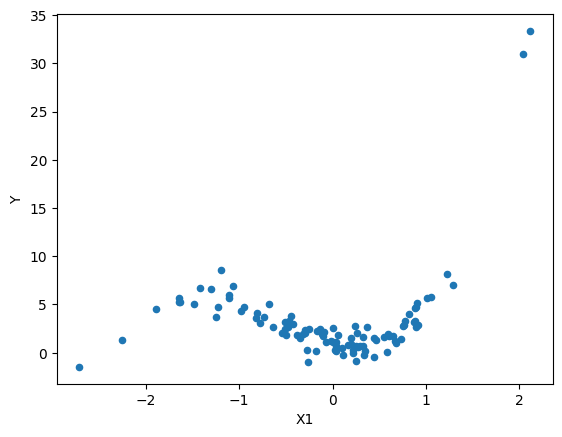

In [64]:
import numpy as np

rng = np.random.default_rng(1)

X = rng.normal(size=100)
epsilon = rng.normal(size=100)

beta0 = 1
beta1 = -1
beta2 = 4
beta3 = 2

Y = beta0 + beta1*X + beta1*X + beta2*X**2 + beta3*X**3 + epsilon

import pandas as pd

df = pd.DataFrame({
    "X1": X,
    "X2": X**2,
    "X3": X**3,
    "X4": X**4,
    "X5": X**5,
    "X6": X**6,
    "X7": X**7,
    "X8": X**8,
    "X9": X**9,
    "X10": X**10,
    "Y": Y
})

df.plot.scatter("X1", "Y");

In [65]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [66]:
from functools import partial
from ISLP.models import ModelSpec as MS
import statsmodels.api as sm

Y = df["Y"]

design = MS(df.columns.drop("Y"))
X = design.fit_transform(df)

sigma2 = sm.OLS(Y, X).fit().scale

neg_Cp = partial(nCp, sigma2)

In [67]:
from ISLP.models import Stepwise, sklearn_selected

strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

df_selected = sklearn_selected(sm.OLS,
                               strategy,
                               scoring=neg_Cp)
df_selected.fit(df, Y)
df_selected.selected_state_

('X1', 'X10', 'X2', 'X3')

In [68]:
df_selected.model_.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     560.7
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           3.91e-65
Time:                        21:55:41   Log-Likelihood:                -135.03
No. Observations:                 100   AIC:                             280.1
Df Residuals:                      95   BIC:                             293.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0534      0.119      8.853      0.000       0.817       1.290
X1            -2.2244      0.206    -10.805      0.000      -2.633      -1.816
X10            0.0003   8.16e-05      3.304      0.001       0.000       0.000
X2             3.7590      0.111     33.847      0.000       3.538       3.979
X3             2.1119      0.078     27.003      0.000       1.957       2.267
==============================================================================
Omnibus:                        2.731   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                2.548
Skew:                           0.072   Prob(JB):                        0.280
Kurtosis:                       3.769   Cond. No.                     4.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [69]:
strategy = Stepwise.first_peak(design,
                               direction='backwards',
                               max_terms=len(design.terms))

df_selected = sklearn_selected(sm.OLS,
                               strategy,
                               scoring=neg_Cp)
df_selected.fit(df, Y)
df_selected.selected_state_

('X1', 'X10', 'X2', 'X3')

Both approaches weirdly picked $X^{10}$ as a significant predictor. This is probably due to the noise in our data. Its p-value is also suprisingly significant, making it a clear case of an overfitting model.

In [70]:
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as skm

lambdas = 10**np.linspace(8, -2, 100) / Y.std()

scaler = StandardScaler(with_mean=True,  with_std=True)

K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)


lasso = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=1,
                           cv=kfold)

pipe = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lasso)])
pipe.fit(X, Y)

tuned_lasso = pipe.named_steps['lasso']
tuned_lasso.alpha_


np.float64(0.017425696359689727)

In [71]:
tuned_lasso.coef_

array([ 0.        , -1.70798938,  4.43804126,  5.67997123,  0.        ,
        0.25552816,  0.        ,  0.        ,  0.        , -0.        ,
        0.56444183])

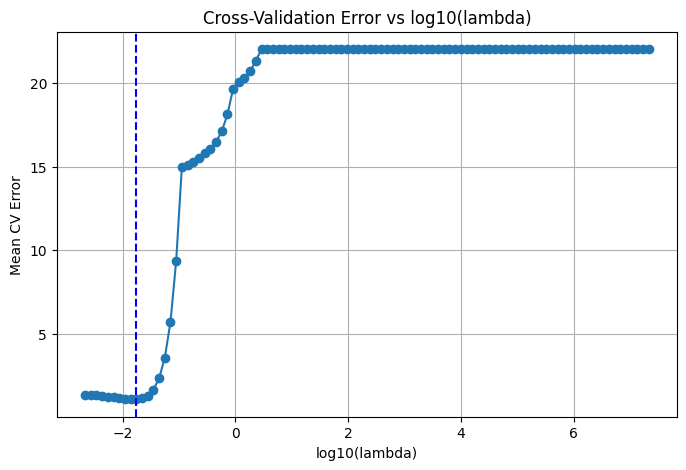

In [72]:
import matplotlib.pyplot as plt
import numpy as np

mean_cv_error = tuned_lasso.mse_path_.mean(axis=1)
lambdas = tuned_lasso.alphas_

plt.figure(figsize=(8, 5))
plt.plot(np.log10(lambdas), mean_cv_error, marker='o')
plt.axvline(np.log10(tuned_lasso.alpha_), c='b', ls='--')
plt.xlabel('log10(lambda)')
plt.ylabel('Mean CV Error')
plt.title('Cross-Validation Error vs log10(lambda)')
plt.grid(True)
plt.show()

Now, we can still that the $X, X^2, X^3$ got picked, as expected. This time also, like the forward and backward stepwise, $X^{10}$ got picked too, along with $X^5$. This demonstrates that such approaches aren't 100% reliable and may require further analysis and testings before validating the model, since the resulting model would overfit on real data.

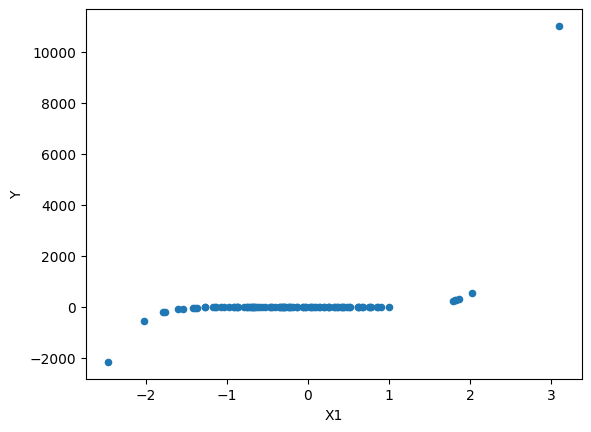

In [73]:
X = rng.normal(size=100)
epsilon = rng.normal(size=100)

beta0 = 1
beta7 = 4

Y = beta0 + beta7*X**7 + epsilon

import pandas as pd

df = pd.DataFrame({
    "X1": X,
    "X2": X**2,
    "X3": X**3,
    "X4": X**4,
    "X5": X**5,
    "X6": X**6,
    "X7": X**7,
    "X8": X**8,
    "X9": X**9,
    "X10": X**10,
    "Y": Y
})

df.plot.scatter("X1", "Y");

In [74]:
Y = df["Y"]

design = MS(df.columns.drop("Y"))
X = design.fit_transform(df)

sigma2 = sm.OLS(Y, X).fit().scale

neg_Cp = partial(nCp, sigma2)

In [75]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

df_selected = sklearn_selected(sm.OLS,
                               strategy,
                               scoring=neg_Cp)
df_selected.fit(df, Y)
df_selected.selected_state_

('X7',)

In [76]:
lasso = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=1,
                           cv=kfold)

pipe = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lasso)])
pipe.fit(X, Y)

tuned_lasso = pipe.named_steps['lasso']
tuned_lasso.alpha_

np.float64(0.0021483212939550915)

In [77]:
tuned_lasso.coef_

array([   0.        ,   24.5875437 ,  -12.60622314, -230.01010302,
        -14.77820902,  717.65464908,   83.10709667,  374.1374837 ,
          6.21131389,  190.72144223,  -23.18710828])

In the given simulation, the true model includes only the $X^7$ term, which forward stepwise regression correctly identifies as the sole predictor. However, when using Lasso (via **ElasticNetCV** with **l1_ratio=1**), the model assigns nonzero coefficients to several polynomial terms from $X^2$ to $X^{10}$. This discrepancy arises primarily due to multicollinearity: powers of $X$ are highly correlated, and Lasso tends to distribute coefficient weight across correlated predictors rather than selecting just one. Additionally, since Lasso minimizes prediction error with an $L_1$ penalty, it may include multiple terms that slightly improve cross-validated performance, even if they are not truly part of the underlying data-generating process. Feature standardization (using **StandardScaler**) is necessary for Lasso but can amplify this effect by equalizing feature scales, making it harder for Lasso to distinguish among highly correlated inputs. In contrast, forward stepwise selects predictors sequentially based on maximal improvement, which in this clean simulation correctly isolates the signal from $X^7$.